# Import dependencies

In [2]:
import pandas as pd
from plot import line_plot
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from models import SIR,SIRD
from prediction import Predicter
from simulator import simulation
from datetime import timedelta
import numpy as np
from estimator import Estimater
from utilities import select_area, show_trend, create_target_df
%matplotlib inline
plt.rcParams["figure.figsize"] = [10, 5]

# Pre-processing raw data

In [3]:
time_format = "%d%b%Y %H:%M"
datetime.now().strftime(time_format)

raw = pd.read_csv("./data/covid_19_data.csv")
data_cols = ["Infected", "Deaths", "Recovered"]
rate_cols = ["Fatal per Confirmed", "Recovered per Confirmed", "Fatal per (Fatal or Recovered)"]
variable_dict = {"Susceptible": "S", "Infected": "I", "Recovered": "R", "Deaths": "D"}
ncov_df = raw.rename({"ObservationDate": "Date", "Province/State": "Province"}, axis=1)
ncov_df["Date"] = pd.to_datetime(ncov_df["Date"])
ncov_df["Country"] = ncov_df["Country/Region"].replace(
    {
        "Mainland China": "China",
        "Hong Kong SAR": "Hong Kong",
        "Taipei and environs": "Taiwan",
        "Iran (Islamic Republic of)": "Iran",
        "Republic of Korea": "South Korea",
        "Republic of Ireland": "Ireland",
        "Macao SAR": "Macau",
        "Russian Federation": "Russia",
        "Republic of Moldova": "Moldova",
        "Taiwan*": "Taiwan",
        "Cruise Ship": "Others",
        "United Kingdom": "UK",
        "Viet Nam": "Vietnam",
        "Czechia": "Czech Republic",
        "St. Martin": "Saint Martin",
        "Cote d'Ivoire": "Ivory Coast",
        "('St. Martin',)": "Saint Martin",
        "Congo (Kinshasa)": "Congo",
    }
)
ncov_df["Province"] = ncov_df["Province"].fillna("-").replace(
    {
        "Cruise Ship": "Diamond Princess cruise ship",
        "Diamond Princess": "Diamond Princess cruise ship"
    }
)

ncov_df["Infected"] = ncov_df["Confirmed"] - ncov_df["Deaths"] - ncov_df["Recovered"]
ncov_df[data_cols] = ncov_df[data_cols].astype(int)
ncov_df = ncov_df.loc[:, ["Date", "Country", "Province", *data_cols]]
print(ncov_df.tail())
print(ncov_df.info())
ncov_df.describe(include="all").fillna("-")
pd.DataFrame(ncov_df.isnull().sum()).T
", ".join(ncov_df["Country"].unique().tolist())

           Date                         Country                      Province  \
5627 2020-03-14                              US          Virgin Islands, U.S.   
5628 2020-03-14                              UK                     Gibraltar   
5629 2020-03-14                       Australia  Diamond Princess cruise ship   
5630 2020-03-14                              US                 West Virginia   
5631 2020-03-14  occupied Palestinian territory                             -   

      Infected  Deaths  Recovered  
5627         1       0          0  
5628         0       0          1  
5629         0       0          0  
5630         0       0          0  
5631         0       0          0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5632 entries, 0 to 5631
Data columns (total 6 columns):
Date         5632 non-null datetime64[ns]
Country      5632 non-null object
Province     5632 non-null object
Infected     5632 non-null int64
Deaths       5632 non-null int64
Recovered    56

'China, Hong Kong, Macau, Taiwan, US, Japan, Thailand, South Korea, Singapore, Philippines, Malaysia, Vietnam, Australia, Mexico, Brazil, Colombia, France, Nepal, Canada, Cambodia, Sri Lanka, Ivory Coast, Germany, Finland, United Arab Emirates, India, Italy, UK, Russia, Sweden, Spain, Belgium, Others, Egypt, Iran, Israel, Lebanon, Iraq, Oman, Afghanistan, Bahrain, Kuwait, Austria, Algeria, Croatia, Switzerland, Pakistan, Georgia, Greece, North Macedonia, Norway, Romania, Denmark, Estonia, Netherlands, San Marino,  Azerbaijan, Belarus, Iceland, Lithuania, New Zealand, Nigeria, North Ireland, Ireland, Luxembourg, Monaco, Qatar, Ecuador, Azerbaijan, Czech Republic, Armenia, Dominican Republic, Indonesia, Portugal, Andorra, Latvia, Morocco, Saudi Arabia, Senegal, Argentina, Chile, Jordan, Ukraine, Saint Barthelemy, Hungary, Faroe Islands, Gibraltar, Liechtenstein, Poland, Tunisia, Palestine, Bosnia and Herzegovina, Slovenia, South Africa, Bhutan, Cameroon, Costa Rica, Peru, Serbia, Slovaki

# Visualize data for the world

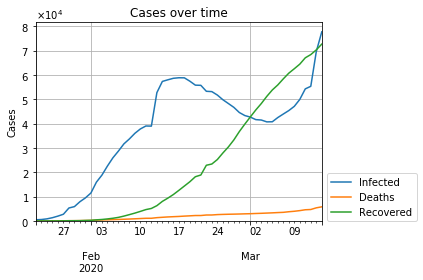

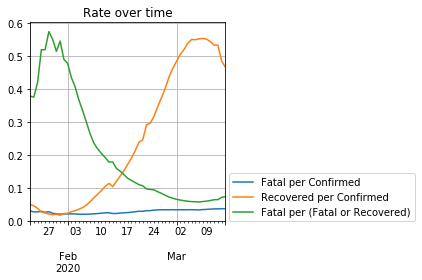

In [4]:
total_df = ncov_df.groupby("Date").sum()
total_df[rate_cols[0]] = total_df["Deaths"] / total_df[data_cols].sum(axis=1)
total_df[rate_cols[1]] = total_df["Recovered"] / total_df[data_cols].sum(axis=1)
total_df[rate_cols[2]] = total_df["Deaths"] / (total_df["Deaths"] + total_df["Recovered"])
total_df.tail()
pd.plotting.register_matplotlib_converters()
line_plot(total_df[data_cols], title="Cases over time")
line_plot(total_df[rate_cols], "Rate over time", ylabel="", math_scale=False)
plt.show()

# Visualize data for Norway

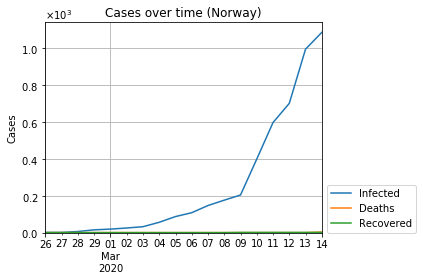

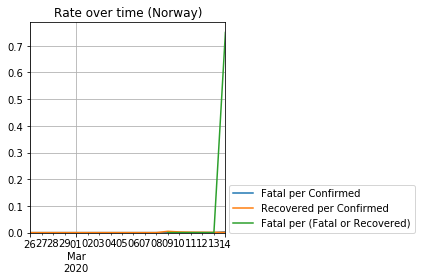

In [5]:
total_df = ncov_df.loc[ncov_df["Country"] == "Norway", :].groupby("Date").sum()
total_df[rate_cols[0]] = total_df["Deaths"] / total_df[data_cols].sum(axis=1)
total_df[rate_cols[1]] = total_df["Recovered"] / total_df[data_cols].sum(axis=1)
total_df[rate_cols[2]] = total_df["Deaths"] / (total_df["Deaths"] + total_df["Recovered"])
total_df.tail()
line_plot(total_df[data_cols], title="Cases over time (Norway)")
line_plot(total_df[rate_cols], "Rate over time (Norway)", ylabel="", math_scale=False)
plt.show()

In [6]:
population_date = "15Mar2020"
_dict = {
    "Global": "7,794,798,729",
    "China": "1,439,323,774",
    "Japan": "126,476,458",
    "South Korea": "51,269,182",
    "Italy": "60,461,827",
    "Iran": "83,992,953",
    "Norway":"5,421,241",
    "India": "1,380,004,385",
    "USA": "331,002,647",

}
population_dict = {k: int(v.replace(",", "")) for (k, v) in _dict.items()}
df = pd.io.json.json_normalize(population_dict)
df.index = [f"Total population on {population_date}"]
df

,Global,China,Japan,South Korea,Italy,Iran,Norway,India,USA
Total population on 15Mar2020,7794798729,1439323774,126476458,51269182,60461827,83992953,5421241,1380004385,331002647


# Prediction with SIR model

### What is SIR model?
SIR model is a simple mathematical model to understand outbreak of infectious diseases.  
[The SIR epidemic model - Learning Scientific Programming with Python](https://scipython.com/book/chapter-8-scipy/additional-examples/the-sir-epidemic-model/)

 * S: Susceptible (=All - Confirmed)
 * I: Infected (=Confirmed - Recovered - Deaths)
 * R: Recovered or Died (=Recovered + Deaths)
 
Note: THIS IS NOT THE GENERAL MODEL!  
Though R in SIR model is "Recovered and have immunity", I defined "R as Recovered or Died". This is because mortality rate cannot be ignored in the real data of COVID-19.

Model:  
S + I $\overset{\beta}{\longrightarrow}$ 2I  
I $\overset{\gamma}{\longrightarrow}$ R

$\beta$: Effective contact rate [1/min]  
$\gamma$: Recovery(+Mortality) rate [1/min]  

Ordinary Differential Equation (ODE):   
$\frac{\mathrm{d}S}{\mathrm{d}T}= - N^{-1}\beta S I$  
$\frac{\mathrm{d}I}{\mathrm{d}T}= N^{-1}\beta S I - \gamma I$  
$\frac{\mathrm{d}R}{\mathrm{d}T}= \gamma I$  

Where $N=S+I+R$ is the total population, $T$ is the elapsed time from the start date.

### Non-dimensional SIR model
To simplify the model, the units of the variables should be removed from ODE.

Set $(S, I, R) = N \times (x, y, z)$ and $(T, \beta, \gamma) = (\tau t, \tau^{-1} \rho, \tau^{-1} \sigma)$.  

This results in the ODE  
$\frac{\mathrm{d}x}{\mathrm{d}t}= - \rho x y$  
$\frac{\mathrm{d}y}{\mathrm{d}t}= \rho x y - \sigma y$  
$\frac{\mathrm{d}z}{\mathrm{d}t}= \sigma y$  

Where $N$ is the total population and $\tau$ is a coefficient ([min], is an integer to simplify).  

The range of variables and parameters:  
$0 < (x, y, z, \rho, \sigma) < 1$  
$1\leq \tau \leq 1440$  

Basic reproduction number, Non-dimentional parameter, is defined as  
$R_0 = \rho \sigma^{-1} = \beta \gamma^{-1}$  

Estimated Mean Values of $R_0$:  
$R_0$ means "the average number of secondary infections caused by an infected host" ([Infection Modeling — Part 1](https://towardsdatascience.com/infection-modeling-part-1-87e74645568a)).  
(Secondary data: [Van den Driessche, P., & Watmough, J. (2002).](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6002118))  
2.06: Zika in South America, 2015-2016  
1.51: Ebola in Guinea, 2014  
1.33: H1N1 influenza in South Africa, 2009  
3.5 : SARS in 2002-2003
1.68: H2N2 influenza in US, 1957  
3.8 : Fall wave of 1918 Spanish influenza in Genova
1.5 : Spring wave of 1918 Spanish influenza in Genova

When $x=\frac{1}{R_0}$, $\frac{\mathrm{d}y}{\mathrm{d}t}=0$. This means that the max value of confirmed ($=y+z$) is $1-\frac{1}{R_0}$.

In [7]:
train_dataset = SIR.create_dataset(
    ncov_df, population_dict["Global"] - population_dict["China"], excluded_places=[("China", None)]
)
train_start_date, train_initials, train_Tend, train_df = train_dataset
print([train_start_date.strftime(time_format), train_initials, train_Tend])

['22Jan2020 00:00', array([9.99999999e-01, 1.25875722e-09, 0.00000000e+00]), 74880]


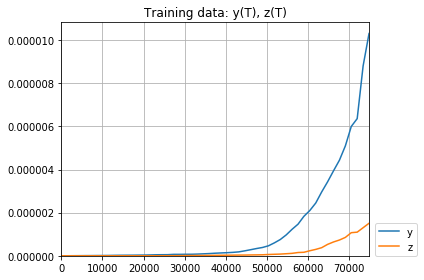

In [8]:
line_plot(
    train_df.set_index("T").drop("x", axis=1),
    "Training data: y(T), z(T)", math_scale=False, ylabel=""
)

**Note: We cannot convert $T$ to $t$ because $\tau$ has not been determined yet.**

### Example of non-dimensional SIR model
For example, set $R_0 = 2.5, \rho=0.2$.

In [9]:
eg_r0, eg_rho = (2.5, 0.2)
eg_sigma = eg_rho / eg_r0

In [10]:
%%time
eg_df = simulation(SIR, train_initials, step_n=300, rho=eg_rho, sigma=eg_sigma)
eg_df.tail()

CPU times: user 10.5 ms, sys: 0 ns, total: 10.5 ms
Wall time: 10.2 ms


,t,x,y,z
296,296,0.108343,0.000628,0.891029
297,297,0.108330,0.000592,0.891078
298,298,0.108317,0.000559,0.891124
299,299,0.108306,0.000527,0.891167
300,300,0.108295,0.000497,0.891208


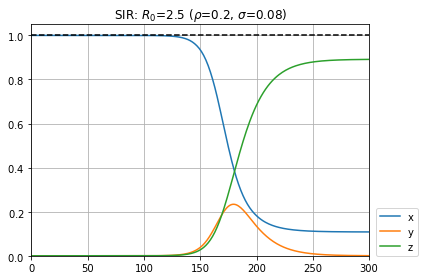

In [11]:
line_plot(
    eg_df.set_index("t"),
    title=r"SIR: $R_0$={0} ($\rho$={1}, $\sigma$={2})".format(eg_r0, eg_rho, eg_sigma),
    ylabel="",
    h=1
)

### Test of hyperparameter optimization using example data
To test the hyperparameter optimization functions defeined in this notebook, we will estimate the SIR model parameters using the example data and example $\tau=1440$ [min] and total population 1,000,000.

In [12]:
# Set the example conditions
eg_tau = 1440
eg_start_date = ncov_df["Date"].min()
eg_total_population = 1000000
# Create dataset in the format of ncov_df
eg_ori_df = pd.DataFrame(
    {
        "Date": (eg_df["t"] * eg_tau).apply(lambda x: timedelta(minutes=x)) + eg_start_date,
        "Country": "Example",
        "Province": "Example"
    }
)
eg_ori_df["Infected"] = (eg_df["y"] * eg_total_population).astype(int)
eg_ori_df["Deaths"] = (eg_df["z"] * eg_total_population * 0.02).astype(int)
eg_ori_df["Recovered"] = (eg_df["z"] * eg_total_population * 0.98).astype(int)
eg_ori_df.tail()

,Date,Country,Province,Infected,Deaths,Recovered
296,2020-11-13,Example,Example,627,17820,873208
297,2020-11-14,Example,Example,592,17821,873256
298,2020-11-15,Example,Example,558,17822,873301
299,2020-11-16,Example,Example,526,17823,873344
300,2020-11-17,Example,Example,497,17824,873384


### Hyperparameter optimization
Using Optuna package, ($\rho, \sigma, \tau$) will be estimated by model fitting.

In [13]:
%%time
sir_estimater = Estimater(
    SIR, ncov_df, population_dict["Global"] - population_dict["China"],
    name="Total except China", excluded_places=[("China", None)]
)
sir_dict = sir_estimater.run()

[I 2020-03-16 08:46:56,633] Finished trial#1 resulted in value: 9362361310.168825. Current best value is 9362361310.168825 with parameters: {'tau': 1056, 'rho': 0.11594983700509842, 'sigma': 0.012486329499967037}.
[I 2020-03-16 08:46:56,722] Finished trial#0 resulted in value: 8768640282.482086. Current best value is 8768640282.482086 with parameters: {'tau': 671, 'rho': 0.07586757250100783, 'sigma': 0.010449141653666092}.
[I 2020-03-16 08:46:56,805] Finished trial#3 resulted in value: 9925541809.61575. Current best value is 8768640282.482086 with parameters: {'tau': 671, 'rho': 0.07586757250100783, 'sigma': 0.010449141653666092}.
[I 2020-03-16 08:46:56,873] Finished trial#2 resulted in value: 13753070179.030338. Current best value is 8768640282.482086 with parameters: {'tau': 671, 'rho': 0.07586757250100783, 'sigma': 0.010449141653666092}.
[I 2020-03-16 08:46:57,031] Finished trial#4 resulted in value: 10178816665.797604. Current best value is 8768640282.482086 with parameters: {'tau'

[I 2020-03-16 08:47:01,796] Finished trial#36 resulted in value: 5334723221.312852. Current best value is 4054507138.4793825 with parameters: {'tau': 1271, 'rho': 0.18287839279123683, 'sigma': 0.024613537767424483}.
[I 2020-03-16 08:47:02,015] Finished trial#39 resulted in value: 13591730605.91644. Current best value is 4054507138.4793825 with parameters: {'tau': 1271, 'rho': 0.18287839279123683, 'sigma': 0.024613537767424483}.
[I 2020-03-16 08:47:02,202] Finished trial#41 resulted in value: 9382829623.83573. Current best value is 4054507138.4793825 with parameters: {'tau': 1271, 'rho': 0.18287839279123683, 'sigma': 0.024613537767424483}.
[I 2020-03-16 08:47:02,492] Finished trial#40 resulted in value: 14537190911.103338. Current best value is 4054507138.4793825 with parameters: {'tau': 1271, 'rho': 0.18287839279123683, 'sigma': 0.024613537767424483}.
[I 2020-03-16 08:47:02,635] Finished trial#42 resulted in value: 8876304586.250612. Current best value is 4054507138.4793825 with parame

[I 2020-03-16 08:47:07,311] Finished trial#76 resulted in value: 3711571467.3673234. Current best value is 3619779390.105523 with parameters: {'tau': 1397, 'rho': 0.19759751142501308, 'sigma': 0.023945382859070177}.
[I 2020-03-16 08:47:07,432] Finished trial#75 resulted in value: 3748418975.0625987. Current best value is 3619779390.105523 with parameters: {'tau': 1397, 'rho': 0.19759751142501308, 'sigma': 0.023945382859070177}.
[I 2020-03-16 08:47:07,618] Finished trial#78 resulted in value: 3752575542.8074894. Current best value is 3619779390.105523 with parameters: {'tau': 1397, 'rho': 0.19759751142501308, 'sigma': 0.023945382859070177}.
[I 2020-03-16 08:47:07,722] Finished trial#77 resulted in value: 3725169029.897859. Current best value is 3619779390.105523 with parameters: {'tau': 1397, 'rho': 0.19759751142501308, 'sigma': 0.023945382859070177}.
[I 2020-03-16 08:47:07,804] Finished trial#79 resulted in value: 3724454044.311682. Current best value is 3619779390.105523 with paramete

[I 2020-03-16 08:47:13,410] Finished trial#114 resulted in value: 3842314884.3742843. Current best value is 3619779390.105523 with parameters: {'tau': 1397, 'rho': 0.19759751142501308, 'sigma': 0.023945382859070177}.
[I 2020-03-16 08:47:13,481] Finished trial#113 resulted in value: 3713772961.749106. Current best value is 3619779390.105523 with parameters: {'tau': 1397, 'rho': 0.19759751142501308, 'sigma': 0.023945382859070177}.
[I 2020-03-16 08:47:13,681] Finished trial#116 resulted in value: 3715642927.269589. Current best value is 3619779390.105523 with parameters: {'tau': 1397, 'rho': 0.19759751142501308, 'sigma': 0.023945382859070177}.
[I 2020-03-16 08:47:13,780] Finished trial#117 resulted in value: 3709710853.5080876. Current best value is 3619779390.105523 with parameters: {'tau': 1397, 'rho': 0.19759751142501308, 'sigma': 0.023945382859070177}.
[I 2020-03-16 08:47:13,867] Finished trial#115 resulted in value: 3705904720.1924167. Current best value is 3619779390.105523 with par

[I 2020-03-16 08:47:18,466] Finished trial#153 resulted in value: 3936888484.192459. Current best value is 3542995787.570173 with parameters: {'tau': 1407, 'rho': 0.1967563009390416, 'sigma': 0.023300358352699217}.
[I 2020-03-16 08:47:18,610] Finished trial#154 resulted in value: 3857154654.817626. Current best value is 3542995787.570173 with parameters: {'tau': 1407, 'rho': 0.1967563009390416, 'sigma': 0.023300358352699217}.
[I 2020-03-16 08:47:18,725] Finished trial#155 resulted in value: 3559850763.4493036. Current best value is 3542995787.570173 with parameters: {'tau': 1407, 'rho': 0.1967563009390416, 'sigma': 0.023300358352699217}.
[I 2020-03-16 08:47:18,881] Finished trial#143 resulted in value: 7043025026.679565. Current best value is 3542995787.570173 with parameters: {'tau': 1407, 'rho': 0.1967563009390416, 'sigma': 0.023300358352699217}.
[I 2020-03-16 08:47:18,993] Finished trial#156 resulted in value: 3502887486.4960556. Current best value is 3502887486.4960556 with paramet

[I 2020-03-16 08:47:23,606] Finished trial#190 resulted in value: 3796990743.812227. Current best value is 3502887486.4960556 with parameters: {'tau': 1406, 'rho': 0.1966378714555312, 'sigma': 0.02373931673835304}.
[I 2020-03-16 08:47:23,768] Finished trial#192 resulted in value: 3914649308.919489. Current best value is 3502887486.4960556 with parameters: {'tau': 1406, 'rho': 0.1966378714555312, 'sigma': 0.02373931673835304}.
[I 2020-03-16 08:47:23,880] Finished trial#186 resulted in value: 9297046201.044296. Current best value is 3502887486.4960556 with parameters: {'tau': 1406, 'rho': 0.1966378714555312, 'sigma': 0.02373931673835304}.
[I 2020-03-16 08:47:24,026] Finished trial#193 resulted in value: 3924883048.049806. Current best value is 3502887486.4960556 with parameters: {'tau': 1406, 'rho': 0.1966378714555312, 'sigma': 0.02373931673835304}.
[I 2020-03-16 08:47:24,188] Finished trial#194 resulted in value: 3565515496.6154056. Current best value is 3502887486.4960556 with paramete

[I 2020-03-16 08:47:28,978] Finished trial#226 resulted in value: 4253678518.2518444. Current best value is 3502887486.4960556 with parameters: {'tau': 1406, 'rho': 0.1966378714555312, 'sigma': 0.02373931673835304}.
[I 2020-03-16 08:47:29,046] Finished trial#228 resulted in value: 3957890580.148347. Current best value is 3502887486.4960556 with parameters: {'tau': 1406, 'rho': 0.1966378714555312, 'sigma': 0.02373931673835304}.
[I 2020-03-16 08:47:29,252] Finished trial#229 resulted in value: 3650761487.476273. Current best value is 3502887486.4960556 with parameters: {'tau': 1406, 'rho': 0.1966378714555312, 'sigma': 0.02373931673835304}.
[I 2020-03-16 08:47:29,381] Finished trial#231 resulted in value: 4234547895.663338. Current best value is 3502887486.4960556 with parameters: {'tau': 1406, 'rho': 0.1966378714555312, 'sigma': 0.02373931673835304}.
[I 2020-03-16 08:47:29,516] Finished trial#230 resulted in value: 3973026057.871451. Current best value is 3502887486.4960556 with paramete

[I 2020-03-16 08:47:34,400] Finished trial#266 resulted in value: 3690362584.150006. Current best value is 3476061980.048026 with parameters: {'tau': 1407, 'rho': 0.19821085120249796, 'sigma': 0.023786261030958978}.
[I 2020-03-16 08:47:34,588] Finished trial#268 resulted in value: 3574967013.921849. Current best value is 3476061980.048026 with parameters: {'tau': 1407, 'rho': 0.19821085120249796, 'sigma': 0.023786261030958978}.
[I 2020-03-16 08:47:34,736] Finished trial#267 resulted in value: 3734885205.0278506. Current best value is 3476061980.048026 with parameters: {'tau': 1407, 'rho': 0.19821085120249796, 'sigma': 0.023786261030958978}.
[I 2020-03-16 08:47:34,923] Finished trial#269 resulted in value: 3772027472.1019154. Current best value is 3476061980.048026 with parameters: {'tau': 1407, 'rho': 0.19821085120249796, 'sigma': 0.023786261030958978}.
[I 2020-03-16 08:47:35,037] Finished trial#270 resulted in value: 4240033268.727838. Current best value is 3476061980.048026 with para

[I 2020-03-16 08:47:40,072] Finished trial#303 resulted in value: 7114408707.948715. Current best value is 3476061980.048026 with parameters: {'tau': 1407, 'rho': 0.19821085120249796, 'sigma': 0.023786261030958978}.
[I 2020-03-16 08:47:40,222] Finished trial#302 resulted in value: 3971644781.6305203. Current best value is 3476061980.048026 with parameters: {'tau': 1407, 'rho': 0.19821085120249796, 'sigma': 0.023786261030958978}.
[I 2020-03-16 08:47:40,393] Finished trial#306 resulted in value: 4022237222.528373. Current best value is 3476061980.048026 with parameters: {'tau': 1407, 'rho': 0.19821085120249796, 'sigma': 0.023786261030958978}.
[I 2020-03-16 08:47:40,536] Finished trial#305 resulted in value: 3644878730.8625813. Current best value is 3476061980.048026 with parameters: {'tau': 1407, 'rho': 0.19821085120249796, 'sigma': 0.023786261030958978}.
[I 2020-03-16 08:47:40,691] Finished trial#296 resulted in value: 6289123024.855499. Current best value is 3476061980.048026 with para

[I 2020-03-16 08:47:45,912] Finished trial#341 resulted in value: 3635781375.559148. Current best value is 3476061980.048026 with parameters: {'tau': 1407, 'rho': 0.19821085120249796, 'sigma': 0.023786261030958978}.
[I 2020-03-16 08:47:46,081] Finished trial#342 resulted in value: 3937745445.4305673. Current best value is 3476061980.048026 with parameters: {'tau': 1407, 'rho': 0.19821085120249796, 'sigma': 0.023786261030958978}.
[I 2020-03-16 08:47:46,241] Finished trial#343 resulted in value: 3463221671.5067196. Current best value is 3463221671.5067196 with parameters: {'tau': 1407, 'rho': 0.19861278286924416, 'sigma': 0.02320069040029129}.
[I 2020-03-16 08:47:46,417] Finished trial#344 resulted in value: 3721093733.249909. Current best value is 3463221671.5067196 with parameters: {'tau': 1407, 'rho': 0.19861278286924416, 'sigma': 0.02320069040029129}.
[I 2020-03-16 08:47:46,597] Finished trial#345 resulted in value: 3937596862.282705. Current best value is 3463221671.5067196 with par

[I 2020-03-16 08:47:52,787] Finished trial#376 resulted in value: 3964392636.0859427. Current best value is 3463221671.5067196 with parameters: {'tau': 1407, 'rho': 0.19861278286924416, 'sigma': 0.02320069040029129}.
[I 2020-03-16 08:47:52,973] Finished trial#377 resulted in value: 3964752978.6610155. Current best value is 3463221671.5067196 with parameters: {'tau': 1407, 'rho': 0.19861278286924416, 'sigma': 0.02320069040029129}.
[I 2020-03-16 08:47:53,103] Finished trial#378 resulted in value: 3983516750.9804993. Current best value is 3463221671.5067196 with parameters: {'tau': 1407, 'rho': 0.19861278286924416, 'sigma': 0.02320069040029129}.
[I 2020-03-16 08:47:53,305] Finished trial#379 resulted in value: 4249623841.765489. Current best value is 3463221671.5067196 with parameters: {'tau': 1407, 'rho': 0.19861278286924416, 'sigma': 0.02320069040029129}.
[I 2020-03-16 08:47:53,433] Finished trial#381 resulted in value: 5102982945.940845. Current best value is 3463221671.5067196 with pa

[I 2020-03-16 08:47:59,927] Finished trial#414 resulted in value: 3688575837.9624753. Current best value is 3463221671.5067196 with parameters: {'tau': 1407, 'rho': 0.19861278286924416, 'sigma': 0.02320069040029129}.
[I 2020-03-16 08:48:00,077] Finished trial#415 resulted in value: 3862355972.9997077. Current best value is 3463221671.5067196 with parameters: {'tau': 1407, 'rho': 0.19861278286924416, 'sigma': 0.02320069040029129}.
[I 2020-03-16 08:48:00,275] Finished trial#416 resulted in value: 3795154905.056144. Current best value is 3463221671.5067196 with parameters: {'tau': 1407, 'rho': 0.19861278286924416, 'sigma': 0.02320069040029129}.
[I 2020-03-16 08:48:00,456] Finished trial#418 resulted in value: 3927606918.750252. Current best value is 3463221671.5067196 with parameters: {'tau': 1407, 'rho': 0.19861278286924416, 'sigma': 0.02320069040029129}.
[I 2020-03-16 08:48:00,619] Finished trial#417 resulted in value: 3989993817.052369. Current best value is 3463221671.5067196 with par

[I 2020-03-16 08:48:06,942] Finished trial#452 resulted in value: 3901963800.737316. Current best value is 3463221671.5067196 with parameters: {'tau': 1407, 'rho': 0.19861278286924416, 'sigma': 0.02320069040029129}.
[I 2020-03-16 08:48:07,145] Finished trial#453 resulted in value: 3963604055.7652783. Current best value is 3463221671.5067196 with parameters: {'tau': 1407, 'rho': 0.19861278286924416, 'sigma': 0.02320069040029129}.
[I 2020-03-16 08:48:07,406] Finished trial#454 resulted in value: 4741798128.807993. Current best value is 3463221671.5067196 with parameters: {'tau': 1407, 'rho': 0.19861278286924416, 'sigma': 0.02320069040029129}.
[I 2020-03-16 08:48:07,612] Finished trial#448 resulted in value: 9641752495.00037. Current best value is 3463221671.5067196 with parameters: {'tau': 1407, 'rho': 0.19861278286924416, 'sigma': 0.02320069040029129}.
[I 2020-03-16 08:48:07,755] Finished trial#455 resulted in value: 3777012695.409864. Current best value is 3463221671.5067196 with param

[I 2020-03-16 08:48:14,065] Finished trial#487 resulted in value: 3974942661.7761755. Current best value is 3463221671.5067196 with parameters: {'tau': 1407, 'rho': 0.19861278286924416, 'sigma': 0.02320069040029129}.
[I 2020-03-16 08:48:14,333] Finished trial#488 resulted in value: 4400033951.759075. Current best value is 3463221671.5067196 with parameters: {'tau': 1407, 'rho': 0.19861278286924416, 'sigma': 0.02320069040029129}.
[I 2020-03-16 08:48:14,460] Finished trial#489 resulted in value: 4015844767.791683. Current best value is 3463221671.5067196 with parameters: {'tau': 1407, 'rho': 0.19861278286924416, 'sigma': 0.02320069040029129}.
[I 2020-03-16 08:48:14,663] Finished trial#490 resulted in value: 4358412684.88912. Current best value is 3463221671.5067196 with parameters: {'tau': 1407, 'rho': 0.19861278286924416, 'sigma': 0.02320069040029129}.
[I 2020-03-16 08:48:14,832] Finished trial#491 resulted in value: 3759134796.761084. Current best value is 3463221671.5067196 with param

CPU times: user 1min 17s, sys: 4.48 s, total: 1min 21s
Wall time: 1min 20s


/home/adil/Dropbox/Courses/BigdataCybernetics/TTK4260/E11/CoronaVirus/estimator.py:157: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



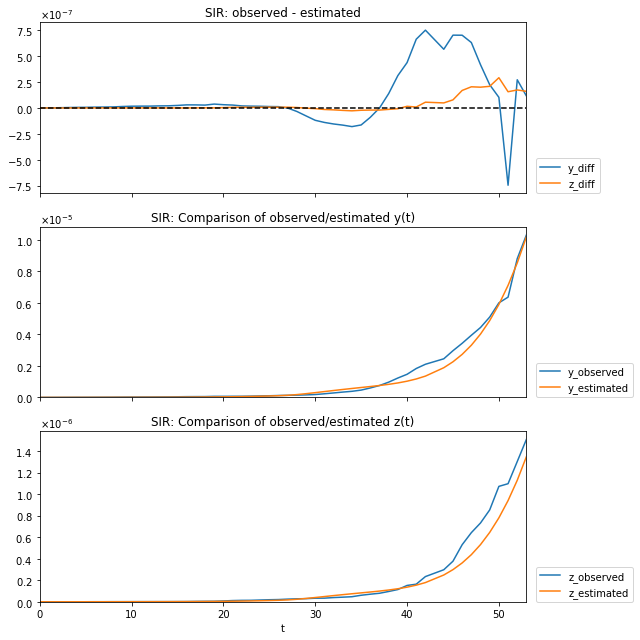

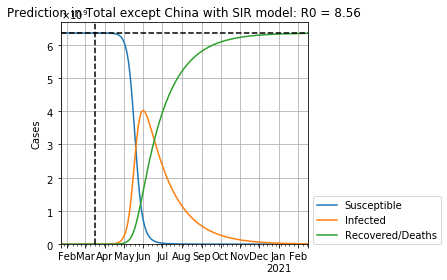

In [14]:
sir_estimater.history_df().head()
#sir_estimater.history_graph()
pd.DataFrame.from_dict({"SIR": sir_dict}, orient="index")
sir_estimater.compare_graph()
sir_estimater.predict_graph(step_n=400)

## Prediction with SIR-D model
Because we can measure the number of fatal cases and recovered cases separately, we can use two variables ("Recovered" and "Deaths") instead of "Recovered + Deaths" in the mathematical model.

### What is SIR-D model?
* S: Susceptible
* I: Infected
* R: Recovered
* D: Fatal

Model:  
S + I $\overset{\beta}{\longrightarrow}$ 2I  
I $\overset{\gamma}{\longrightarrow}$ R  
I $\overset{\alpha}{\longrightarrow}$ D  

$\alpha$: Mortality rate [1/min]  
$\beta$: Effective contact rate [1/min]  
$\gamma$: Recovery rate [1/min]  

Ordinary Differential Equation (ODE):   
$\frac{\mathrm{d}S}{\mathrm{d}T}= - N^{-1}\beta S I$  
$\frac{\mathrm{d}I}{\mathrm{d}T}= N^{-1}\beta S I - (\gamma + \alpha) I$  
$\frac{\mathrm{d}R}{\mathrm{d}T}= \gamma I$  
$\frac{\mathrm{d}D}{\mathrm{d}T}= \alpha I$  

Where $N=S+I+R+D$ is the total population, $T$ is the elapsed time from the start date.

### Non-dimensional SIR-D model
Set $(S, I, R, D) = N \times (x, y, z, z)$ and $(T, \alpha, \beta, \gamma) = (\tau t, \tau^{-1} \kappa, \tau^{-1} \rho, \tau^{-1} \sigma)$.  
This results in the ODE  
$\frac{\mathrm{d}x}{\mathrm{d}t}= - \rho x y$  
$\frac{\mathrm{d}y}{\mathrm{d}t}= \rho x y - (\sigma + \kappa) y$  
$\frac{\mathrm{d}z}{\mathrm{d}t}= \sigma y$  
$\frac{\mathrm{d}w}{\mathrm{d}t}= \kappa y$  

Where $N$ is the total population and $\tau$ is a coefficient ([min], is an integer to simplify).  

The range of variables and parameters:  
$0 < (x, y, z, \kappa, \rho, \sigma) < 1$  
$1\leq \tau \leq 1440$

Reproduction number can be defined as  
$R_0 = \rho (\sigma + \kappa)^{-1} = \beta (\gamma + \alpha)^{-1}$

### Hyperparameter optimization
Using Optuna package, ($\kappa, \rho, \sigma, \tau$) will be estimated by model fitting.

In [15]:
%%time
sird_estimater = Estimater(
    SIRD, ncov_df, population_dict["Global"] - population_dict["China"],
    name="Total except China", excluded_places=[("China", None)]
)
sird_dict = sird_estimater.run()

[I 2020-03-16 08:48:41,896] Finished trial#1 resulted in value: 163476508315.11145. Current best value is 163476508315.11145 with parameters: {'tau': 244, 'kappa': 0.00040356032760706454, 'rho': 0.03161372215763473, 'sigma': 0.003298542175946038}.
[I 2020-03-16 08:48:42,043] Finished trial#2 resulted in value: 131663596083.81052. Current best value is 131663596083.81052 with parameters: {'tau': 228, 'kappa': 4.583241368027163e-05, 'rho': 0.027755281973039142, 'sigma': 0.0025850580925050083}.
[I 2020-03-16 08:48:42,109] Finished trial#3 resulted in value: 104872678948.4938. Current best value is 104872678948.4938 with parameters: {'tau': 793, 'kappa': 0.0008716362183861931, 'rho': 0.0847151566912118, 'sigma': 0.007463620517102735}.
[I 2020-03-16 08:48:42,110] Finished trial#0 resulted in value: 49077122099.62562. Current best value is 49077122099.62562 with parameters: {'tau': 1331, 'kappa': 0.0016242437779755755, 'rho': 0.17815784889333353, 'sigma': 0.016809767501716286}.
[I 2020-03-16

[I 2020-03-16 08:48:46,682] Finished trial#32 resulted in value: 194094458463.73947. Current best value is 41427657899.34279 with parameters: {'tau': 1370, 'kappa': 0.002897747074941768, 'rho': 0.19032551712420948, 'sigma': 0.0189526376345708}.
[I 2020-03-16 08:48:46,855] Finished trial#34 resulted in value: 42408824922.0961. Current best value is 41427657899.34279 with parameters: {'tau': 1370, 'kappa': 0.002897747074941768, 'rho': 0.19032551712420948, 'sigma': 0.0189526376345708}.
[I 2020-03-16 08:48:46,970] Finished trial#35 resulted in value: 41259003378.28363. Current best value is 41259003378.28363 with parameters: {'tau': 1439, 'kappa': 0.002760746543256343, 'rho': 0.19854087281836527, 'sigma': 0.01778984194420952}.
[I 2020-03-16 08:48:47,129] Finished trial#37 resulted in value: 43846944739.52725. Current best value is 41259003378.28363 with parameters: {'tau': 1439, 'kappa': 0.002760746543256343, 'rho': 0.19854087281836527, 'sigma': 0.01778984194420952}.
[I 2020-03-16 08:48:47

[I 2020-03-16 08:48:51,841] Finished trial#66 resulted in value: 45892098172.86178. Current best value is 40205962085.27605 with parameters: {'tau': 1398, 'kappa': 0.0019981956586491577, 'rho': 0.194685610030499, 'sigma': 0.018325591652372426}.
[I 2020-03-16 08:48:51,977] Finished trial#69 resulted in value: 182271091246.20566. Current best value is 40205962085.27605 with parameters: {'tau': 1398, 'kappa': 0.0019981956586491577, 'rho': 0.194685610030499, 'sigma': 0.018325591652372426}.
[I 2020-03-16 08:48:52,080] Finished trial#67 resulted in value: 97531761356.76933. Current best value is 40205962085.27605 with parameters: {'tau': 1398, 'kappa': 0.0019981956586491577, 'rho': 0.194685610030499, 'sigma': 0.018325591652372426}.
[I 2020-03-16 08:48:52,205] Finished trial#68 resulted in value: 47672561163.017265. Current best value is 40205962085.27605 with parameters: {'tau': 1398, 'kappa': 0.0019981956586491577, 'rho': 0.194685610030499, 'sigma': 0.018325591652372426}.
[I 2020-03-16 08:4

[I 2020-03-16 08:48:57,413] Finished trial#99 resulted in value: 38399999710.27027. Current best value is 38399999710.27027 with parameters: {'tau': 1406, 'kappa': 0.001373343559921149, 'rho': 0.19710281370503394, 'sigma': 0.019243372699401885}.
[I 2020-03-16 08:48:57,584] Finished trial#100 resulted in value: 40636240827.59573. Current best value is 38399999710.27027 with parameters: {'tau': 1406, 'kappa': 0.001373343559921149, 'rho': 0.19710281370503394, 'sigma': 0.019243372699401885}.
[I 2020-03-16 08:48:57,709] Finished trial#101 resulted in value: 40330303008.18418. Current best value is 38399999710.27027 with parameters: {'tau': 1406, 'kappa': 0.001373343559921149, 'rho': 0.19710281370503394, 'sigma': 0.019243372699401885}.
[I 2020-03-16 08:48:57,859] Finished trial#103 resulted in value: 43001525139.73315. Current best value is 38399999710.27027 with parameters: {'tau': 1406, 'kappa': 0.001373343559921149, 'rho': 0.19710281370503394, 'sigma': 0.019243372699401885}.
[I 2020-03-16

[I 2020-03-16 08:49:02,092] Finished trial#131 resulted in value: 39653416231.8637. Current best value is 38399999710.27027 with parameters: {'tau': 1406, 'kappa': 0.001373343559921149, 'rho': 0.19710281370503394, 'sigma': 0.019243372699401885}.
[I 2020-03-16 08:49:02,288] Finished trial#134 resulted in value: 45119227321.68947. Current best value is 38399999710.27027 with parameters: {'tau': 1406, 'kappa': 0.001373343559921149, 'rho': 0.19710281370503394, 'sigma': 0.019243372699401885}.
[I 2020-03-16 08:49:02,397] Finished trial#135 resulted in value: 42783418584.95424. Current best value is 38399999710.27027 with parameters: {'tau': 1406, 'kappa': 0.001373343559921149, 'rho': 0.19710281370503394, 'sigma': 0.019243372699401885}.
[I 2020-03-16 08:49:02,512] Finished trial#136 resulted in value: 43004711705.92801. Current best value is 38399999710.27027 with parameters: {'tau': 1406, 'kappa': 0.001373343559921149, 'rho': 0.19710281370503394, 'sigma': 0.019243372699401885}.
[I 2020-03-16

[I 2020-03-16 08:49:07,686] Finished trial#167 resulted in value: 43355694499.2073. Current best value is 38399999710.27027 with parameters: {'tau': 1406, 'kappa': 0.001373343559921149, 'rho': 0.19710281370503394, 'sigma': 0.019243372699401885}.
[I 2020-03-16 08:49:07,895] Finished trial#154 resulted in value: 114289365964.86148. Current best value is 38399999710.27027 with parameters: {'tau': 1406, 'kappa': 0.001373343559921149, 'rho': 0.19710281370503394, 'sigma': 0.019243372699401885}.
[I 2020-03-16 08:49:08,022] Finished trial#169 resulted in value: 43801413682.51557. Current best value is 38399999710.27027 with parameters: {'tau': 1406, 'kappa': 0.001373343559921149, 'rho': 0.19710281370503394, 'sigma': 0.019243372699401885}.
[I 2020-03-16 08:49:08,165] Finished trial#152 resulted in value: 113828583275.4796. Current best value is 38399999710.27027 with parameters: {'tau': 1406, 'kappa': 0.001373343559921149, 'rho': 0.19710281370503394, 'sigma': 0.019243372699401885}.
[I 2020-03-1

[I 2020-03-16 08:49:12,799] Finished trial#200 resulted in value: 41284607289.68547. Current best value is 38399999710.27027 with parameters: {'tau': 1406, 'kappa': 0.001373343559921149, 'rho': 0.19710281370503394, 'sigma': 0.019243372699401885}.
[I 2020-03-16 08:49:13,022] Finished trial#202 resulted in value: 44265903206.32857. Current best value is 38399999710.27027 with parameters: {'tau': 1406, 'kappa': 0.001373343559921149, 'rho': 0.19710281370503394, 'sigma': 0.019243372699401885}.
[I 2020-03-16 08:49:13,197] Finished trial#203 resulted in value: 42449126462.57892. Current best value is 38399999710.27027 with parameters: {'tau': 1406, 'kappa': 0.001373343559921149, 'rho': 0.19710281370503394, 'sigma': 0.019243372699401885}.
[I 2020-03-16 08:49:13,369] Finished trial#204 resulted in value: 46121525517.10117. Current best value is 38399999710.27027 with parameters: {'tau': 1406, 'kappa': 0.001373343559921149, 'rho': 0.19710281370503394, 'sigma': 0.019243372699401885}.
[I 2020-03-1

[I 2020-03-16 08:49:18,267] Finished trial#205 resulted in value: 114898873472.79979. Current best value is 38399999710.27027 with parameters: {'tau': 1406, 'kappa': 0.001373343559921149, 'rho': 0.19710281370503394, 'sigma': 0.019243372699401885}.
[I 2020-03-16 08:49:18,267] Finished trial#232 resulted in value: 42285782561.70292. Current best value is 38399999710.27027 with parameters: {'tau': 1406, 'kappa': 0.001373343559921149, 'rho': 0.19710281370503394, 'sigma': 0.019243372699401885}.
[I 2020-03-16 08:49:18,427] Finished trial#233 resulted in value: 43384396612.6559. Current best value is 38399999710.27027 with parameters: {'tau': 1406, 'kappa': 0.001373343559921149, 'rho': 0.19710281370503394, 'sigma': 0.019243372699401885}.
[I 2020-03-16 08:49:18,616] Finished trial#234 resulted in value: 39094985213.54271. Current best value is 38399999710.27027 with parameters: {'tau': 1406, 'kappa': 0.001373343559921149, 'rho': 0.19710281370503394, 'sigma': 0.019243372699401885}.
[I 2020-03-1

[I 2020-03-16 08:49:23,209] Finished trial#263 resulted in value: 44967134962.76176. Current best value is 38399999710.27027 with parameters: {'tau': 1406, 'kappa': 0.001373343559921149, 'rho': 0.19710281370503394, 'sigma': 0.019243372699401885}.
[I 2020-03-16 08:49:23,329] Finished trial#265 resulted in value: 43240944698.59847. Current best value is 38399999710.27027 with parameters: {'tau': 1406, 'kappa': 0.001373343559921149, 'rho': 0.19710281370503394, 'sigma': 0.019243372699401885}.
[I 2020-03-16 08:49:23,500] Finished trial#266 resulted in value: 43990115653.962685. Current best value is 38399999710.27027 with parameters: {'tau': 1406, 'kappa': 0.001373343559921149, 'rho': 0.19710281370503394, 'sigma': 0.019243372699401885}.
[I 2020-03-16 08:49:23,736] Finished trial#267 resulted in value: 43855623483.56862. Current best value is 38399999710.27027 with parameters: {'tau': 1406, 'kappa': 0.001373343559921149, 'rho': 0.19710281370503394, 'sigma': 0.019243372699401885}.
[I 2020-03-

[I 2020-03-16 08:49:28,748] Finished trial#298 resulted in value: 66569930698.79704. Current best value is 38399999710.27027 with parameters: {'tau': 1406, 'kappa': 0.001373343559921149, 'rho': 0.19710281370503394, 'sigma': 0.019243372699401885}.
[I 2020-03-16 08:49:28,898] Finished trial#299 resulted in value: 58401008752.60483. Current best value is 38399999710.27027 with parameters: {'tau': 1406, 'kappa': 0.001373343559921149, 'rho': 0.19710281370503394, 'sigma': 0.019243372699401885}.
[I 2020-03-16 08:49:29,099] Finished trial#301 resulted in value: 44692530268.2439. Current best value is 38399999710.27027 with parameters: {'tau': 1406, 'kappa': 0.001373343559921149, 'rho': 0.19710281370503394, 'sigma': 0.019243372699401885}.
[I 2020-03-16 08:49:29,216] Finished trial#302 resulted in value: 43735303374.04111. Current best value is 38399999710.27027 with parameters: {'tau': 1406, 'kappa': 0.001373343559921149, 'rho': 0.19710281370503394, 'sigma': 0.019243372699401885}.
[I 2020-03-16

[I 2020-03-16 08:49:35,027] Finished trial#332 resulted in value: 41701360563.52341. Current best value is 38399999710.27027 with parameters: {'tau': 1406, 'kappa': 0.001373343559921149, 'rho': 0.19710281370503394, 'sigma': 0.019243372699401885}.
[I 2020-03-16 08:49:35,239] Finished trial#333 resulted in value: 43257683972.69733. Current best value is 38399999710.27027 with parameters: {'tau': 1406, 'kappa': 0.001373343559921149, 'rho': 0.19710281370503394, 'sigma': 0.019243372699401885}.
[I 2020-03-16 08:49:35,453] Finished trial#335 resulted in value: 40972231573.64356. Current best value is 38399999710.27027 with parameters: {'tau': 1406, 'kappa': 0.001373343559921149, 'rho': 0.19710281370503394, 'sigma': 0.019243372699401885}.
[I 2020-03-16 08:49:35,586] Finished trial#306 resulted in value: 86265639321.45949. Current best value is 38399999710.27027 with parameters: {'tau': 1406, 'kappa': 0.001373343559921149, 'rho': 0.19710281370503394, 'sigma': 0.019243372699401885}.
[I 2020-03-1

[I 2020-03-16 08:49:42,082] Finished trial#365 resulted in value: 40955275389.06401. Current best value is 38379333189.52227 with parameters: {'tau': 1407, 'kappa': 0.0019529825555950977, 'rho': 0.19686094945212798, 'sigma': 0.01882707594680333}.
[I 2020-03-16 08:49:42,295] Finished trial#366 resulted in value: 43275539584.15403. Current best value is 38379333189.52227 with parameters: {'tau': 1407, 'kappa': 0.0019529825555950977, 'rho': 0.19686094945212798, 'sigma': 0.01882707594680333}.
[I 2020-03-16 08:49:42,471] Finished trial#367 resulted in value: 43760226092.10598. Current best value is 38379333189.52227 with parameters: {'tau': 1407, 'kappa': 0.0019529825555950977, 'rho': 0.19686094945212798, 'sigma': 0.01882707594680333}.
[I 2020-03-16 08:49:42,659] Finished trial#368 resulted in value: 40302577966.54016. Current best value is 38379333189.52227 with parameters: {'tau': 1407, 'kappa': 0.0019529825555950977, 'rho': 0.19686094945212798, 'sigma': 0.01882707594680333}.
[I 2020-03-1

[I 2020-03-16 08:49:49,636] Finished trial#389 resulted in value: 102444301059.13477. Current best value is 38379333189.52227 with parameters: {'tau': 1407, 'kappa': 0.0019529825555950977, 'rho': 0.19686094945212798, 'sigma': 0.01882707594680333}.
[I 2020-03-16 08:49:49,932] Finished trial#392 resulted in value: 74370346168.45811. Current best value is 38379333189.52227 with parameters: {'tau': 1407, 'kappa': 0.0019529825555950977, 'rho': 0.19686094945212798, 'sigma': 0.01882707594680333}.
[I 2020-03-16 08:49:50,122] Finished trial#401 resulted in value: 40432431931.712166. Current best value is 38379333189.52227 with parameters: {'tau': 1407, 'kappa': 0.0019529825555950977, 'rho': 0.19686094945212798, 'sigma': 0.01882707594680333}.
[I 2020-03-16 08:49:50,339] Finished trial#398 resulted in value: 60199613065.174034. Current best value is 38379333189.52227 with parameters: {'tau': 1407, 'kappa': 0.0019529825555950977, 'rho': 0.19686094945212798, 'sigma': 0.01882707594680333}.
[I 2020-0

[I 2020-03-16 08:49:55,795] Finished trial#430 resulted in value: 43286070185.617805. Current best value is 38379333189.52227 with parameters: {'tau': 1407, 'kappa': 0.0019529825555950977, 'rho': 0.19686094945212798, 'sigma': 0.01882707594680333}.
[I 2020-03-16 08:49:55,992] Finished trial#431 resulted in value: 42511457721.762375. Current best value is 38379333189.52227 with parameters: {'tau': 1407, 'kappa': 0.0019529825555950977, 'rho': 0.19686094945212798, 'sigma': 0.01882707594680333}.
[I 2020-03-16 08:49:56,269] Finished trial#434 resulted in value: 52464376930.81023. Current best value is 38379333189.52227 with parameters: {'tau': 1407, 'kappa': 0.0019529825555950977, 'rho': 0.19686094945212798, 'sigma': 0.01882707594680333}.
[I 2020-03-16 08:49:56,405] Finished trial#433 resulted in value: 53801873302.79713. Current best value is 38379333189.52227 with parameters: {'tau': 1407, 'kappa': 0.0019529825555950977, 'rho': 0.19686094945212798, 'sigma': 0.01882707594680333}.
[I 2020-03

[I 2020-03-16 08:50:02,441] Finished trial#463 resulted in value: 43487980626.367645. Current best value is 38379333189.52227 with parameters: {'tau': 1407, 'kappa': 0.0019529825555950977, 'rho': 0.19686094945212798, 'sigma': 0.01882707594680333}.
[I 2020-03-16 08:50:02,708] Finished trial#464 resulted in value: 47009874694.50059. Current best value is 38379333189.52227 with parameters: {'tau': 1407, 'kappa': 0.0019529825555950977, 'rho': 0.19686094945212798, 'sigma': 0.01882707594680333}.
[I 2020-03-16 08:50:02,843] Finished trial#465 resulted in value: 46518720005.762245. Current best value is 38379333189.52227 with parameters: {'tau': 1407, 'kappa': 0.0019529825555950977, 'rho': 0.19686094945212798, 'sigma': 0.01882707594680333}.
[I 2020-03-16 08:50:02,983] Finished trial#460 resulted in value: 66564784298.29. Current best value is 38379333189.52227 with parameters: {'tau': 1407, 'kappa': 0.0019529825555950977, 'rho': 0.19686094945212798, 'sigma': 0.01882707594680333}.
[I 2020-03-16

[I 2020-03-16 08:50:08,726] Finished trial#496 resulted in value: 43806516731.930115. Current best value is 38379333189.52227 with parameters: {'tau': 1407, 'kappa': 0.0019529825555950977, 'rho': 0.19686094945212798, 'sigma': 0.01882707594680333}.
[I 2020-03-16 08:50:08,991] Finished trial#499 resulted in value: 48696830279.13657. Current best value is 38379333189.52227 with parameters: {'tau': 1407, 'kappa': 0.0019529825555950977, 'rho': 0.19686094945212798, 'sigma': 0.01882707594680333}.
[I 2020-03-16 08:50:09,099] Finished trial#490 resulted in value: 84791485044.82924. Current best value is 38379333189.52227 with parameters: {'tau': 1407, 'kappa': 0.0019529825555950977, 'rho': 0.19686094945212798, 'sigma': 0.01882707594680333}.
[I 2020-03-16 08:50:09,190] Finished trial#498 resulted in value: 40170732149.82096. Current best value is 38379333189.52227 with parameters: {'tau': 1407, 'kappa': 0.0019529825555950977, 'rho': 0.19686094945212798, 'sigma': 0.01882707594680333}.
[I 2020-03-

CPU times: user 1min 25s, sys: 5.37 s, total: 1min 30s
Wall time: 1min 27s


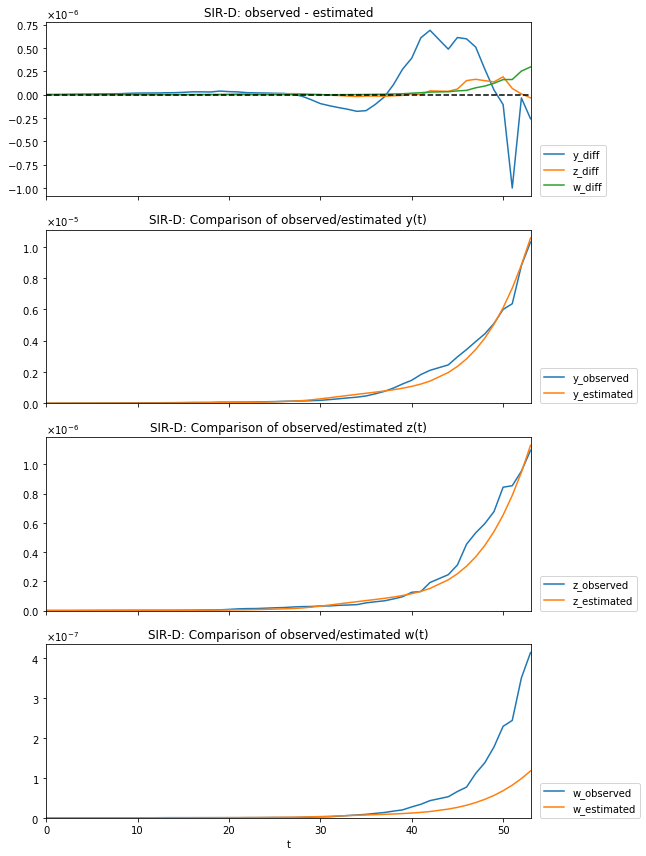

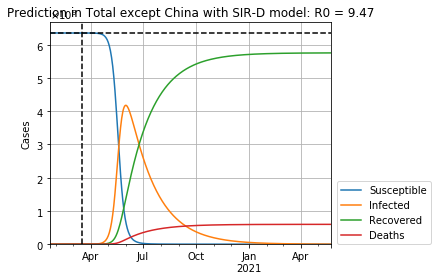

In [16]:
#sird_estimater.history_graph()
pd.DataFrame.from_dict({"SIR": sir_dict, "SIR-D": sird_dict}, orient="index").fillna("-")
sird_estimater.compare_graph()
sird_estimater.predict_graph(step_n=500)